# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
* DPを**Howard's Improvement Algorithm （Policy Function Iteration）**で解く

In [1]:
using Dierckx
using Optim
using Plots
#pyplot()

In [2]:
# グリッドを生成するためのモジュールを読み込む
include("GenerateGrid.jl")

Main.GenerateGrid

### カリブレーション
* パラメータをひとつの変数にまとめる：structを使う

In [3]:
struct Params
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    α::Float64 #資本分配率
    δ::Float64 #固定資本減耗

    # グリッド
    nk::Int64 #資本グリッドの数
    kmax::Float64 #資本グリッドの最大値
    kmin::Float64 #資本グリッドの最小値
    kgrid::Vector{Float64} #資本グリッド

    # 繰り返し計算
    maxit::Int64 # 繰り返し計算の最大値
    tol::Float64 # 計算誤差の許容値(tolerance of error)
end

In [4]:
function calibration()
    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0 # 0.08

    nk = 101
    kmax = 0.5 # 固定資本減耗が0.08の場合、ここを10.0にする
    kmin = 0.05

    # 自作のコードで等分のグリッドを計算
    kgrid = GenerateGrid.grid_uni(kmin, kmax, nk)

    maxit = 1000
    tol = 1e-5

    return Params(β, γ, α, δ, nk, kmax, kmin, kgrid, maxit, tol)
end

calibration (generic function with 1 method)

In [5]:
params = calibration();

---

## 経済学でよく使う関数

In [6]:
include("MyEconFcn.jl")

Main.MyEconFcn

---

## 政策関数を当て推量
* アルゴリズム
    1. 適当に政策関数を当て推量する
    2. その政策関数を使い続けた場合の価値関数を計算する
        * 最適化のステップは不要
        * とりあえず1000回繰り返し計算をしておく
    3. 得られた価値関数の下での最適な政策関数を計算
    4. 得られた新しい政策関数を使って価値関数を計算し直す
        * 上記のステップ2と同じ
    5. 価値関数が収束するまで以上を繰り返す

In [7]:
# 政策関数の当て推量：総資源の半分を使い続ける
pfcn0 = 0.5*(params.kgrid.^params.α + (1-params.δ)*params.kgrid);

## 当て推量した政策関数を使って価値関数を繰り返し計算

In [8]:
"""
k'を1つ与えた際にベルマン方程式の値を返す

### Inputs
`params::Params`: パラメータなどを含むオブジェクト
`wealth::Float64`: 今期利用可能な資産
`kprime::Float64`: 次期の資本量
`vnext::Spline1D`: 次期の価値関数をスプライン近似した際の係数

### Outputs 
`value::Float64`:　"正値のままの"ベルマン方程式
"""
function BellmanEq1(params::Params, wealth::Float64, kprime::Float64, vnext::Spline1D)
    value = MyEconFcn.crra((wealth - kprime), params.γ) + params.β*vnext(kprime)
    return value 
end

BellmanEq1

In [9]:
vfcn0 = zeros(params.nk)
vfcn1 = zeros(params.nk)

# 利用可能な資産をあらかじめ計算しておく
wealth = params.kgrid.^params.α + (1-params.δ)*params.kgrid;

for j = 1:1000
    vnext = Spline1D(params.kgrid, vfcn0, k=3, bc="extrapolate")
    for i = 1:params.nk
        # ずっとpfcn0を使い続ける
        vfcn1[i] = BellmanEq1(params, wealth[i], pfcn0[i], vnext)
    end
    vfcn0 = deepcopy(vfcn1)
end

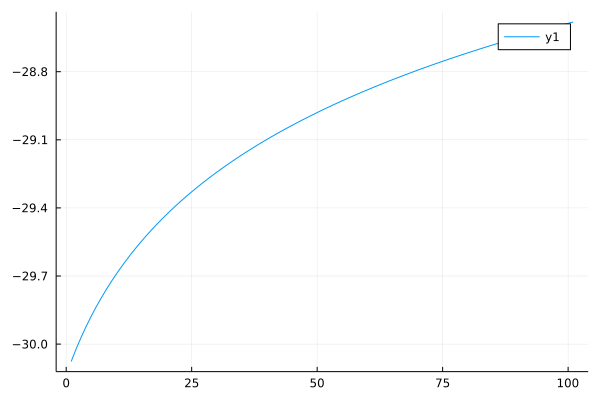

In [10]:
plot(vfcn0)

In [11]:
"""
k'を1つ与えた際にベルマン方程式の値を返す

### Inputs
`num_it::Int64`: 繰り返し計算の回数
`params::Params`: パラメータなどを含むオブジェクト
`policy::Vector{Float64}`: 所与の政策関数

### Outputs 
`vfcn0::Vector{Float64}`:　任意の政策関数を使い続けた際の価値関数
"""
function IterateValue(num_it::Int64, params::Params, policy::Vector{Float64})

    vfcn0 = zeros(params.nk)
    vfcn1 = zeros(params.nk)
    wealth = params.kgrid.^params.α + (1-params.δ)*params.kgrid # 関数の外に出したほうが計算速度はアップ

    for j = 1:num_it
        vnext = Spline1D(params.kgrid, vfcn0, k=3, bc="extrapolate")
        for i = 1:params.nk
            # ずっと同じpolicyを使い続ける
            vfcn1[i] = BellmanEq1(params, wealth[i], policy[i], vnext)
        end
        vfcn0 = deepcopy(vfcn1)
    end
    return vfcn0
end

IterateValue

In [12]:
vfcn0 = IterateValue(1000, params, pfcn0);

---

## 最適化によって政策関数をアップデート

In [13]:
"""
k'を1つ与えた際にベルマン方程式の値を返す

### Inputs
`params::Params`: パラメータなどを含むオブジェクト
`wealth::Float64`: 今期利用可能な資産
`kprime::Float64`: 次期の資本量
`vnext::Spline1D`: 次期の価値関数をスプライン近似した際の係数

### Outputs 
`value::Float64`: 負値にしたベルマン方程式
"""
function BellmanEq2(params, wealth, kprime, vnext)
    value = MyEconFcn.crra((wealth - kprime), params.γ) + params.β*vnext(kprime)
    value = -1*value
    return value 
end

BellmanEq2

In [14]:
# 再計算
pfcn0 = 0.5*(params.kgrid.^params.α + (1-params.δ)*params.kgrid)
vfcn0 = IterateValue(1000, params, pfcn0)
vfcn1 = zeros(params.nk);

In [15]:
# 価値関数を繰り返し計算
for it = 1:params.maxit

    # 次期の価値関数を補間
    vnext = Spline1D(params.kgrid, vfcn0, k=3, bc="extrapolate") #スプライン補間

    for i = 1:params.nk
        BellmanEq!(kprime) = BellmanEq2(params, wealth[i], kprime, vnext)
        res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) # 最適化
        pfcn1[i] = res.minimizer
    end

    # 新たな政策関数を使って価値関数をアップデート
    vfcn1 = IterateValue(1000, params, pfcn1)

    dif1 = maximum(abs.((vfcn1 - vfcn0)./vfcn0)) # 価値関数の繰り返し計算誤差
    dif2 = maximum(abs.((pfcn1 - pfcn0)./pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

    vfcn0 = deepcopy(vfcn1)
    pfcn0 = deepcopy(pfcn1)

    println("iteration counter: $it")
    println("error (value): $dif1")
    println("error (policy): $dif2")
    println()

    if dif1 < params.tol
        break
    end

    if it == params.maxit
        println("The model does not converge...")
    end
end

LoadError: UndefVarError: pfcn1 not defined

---

## PFI
* 上記の説明をまとめて関数化

In [16]:
# 政策関数の当て推量
pfcn0 = 0.5*(params.kgrid.^params.α + (1-params.δ)*params.kgrid)

# 当て推量の下での価値関数
vfcn0 = IterateValue(1000, params, pfcn0)

# 価値関数・政策関数を初期化
pfcn1 = zeros(params.nk)
vfcn1 = zeros(params.nk);

In [17]:
"""
状態変数のみ離散化して操作変数は連続的に値を取る場合の動的計画法(parametric DP)の解法.
アルゴリズムの詳細は、Johnson et al. (1993)を参照

### Inputs
`params::Params`: パラメータ等を含む構造体

### Outputs
`vfcn0::Vector{Float64}`: 計算によって得られた価値関数
`pfcn1::Vector{Float64}`: 計算によって得られた政策関数
"""
function pfi(params::Params)

    # 政策関数の当て推量
    pfcn0 = 0.5*(params.kgrid.^params.α + (1-params.δ)*params.kgrid)

    # 当て推量の下での価値関数
    vfcn0 = IterateValue(1000, params, pfcn0)

    # 価値関数と政策関数を初期化
    pfcn1 = zeros(params.nk)
    vfcn1 = zeros(params.nk)

    # 価値関数を繰り返し計算
    for it = 1:params.maxit

        # 次期の価値関数を補間
        vnext = Spline1D(params.kgrid, vfcn0, k=3, bc="extrapolate") #スプライン補間

        for i = 1:params.nk
            BellmanEq!(kprime) = BellmanEq2(params, wealth[i], kprime, vnext)
            res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) # 最適化
            pfcn1[i] = res.minimizer
        end

        # 新たな政策関数を使って価値関数をアップデート
        vfcn1 = IterateValue(1000, params, pfcn1)

        dif1 = maximum(abs.((vfcn1 - vfcn0)./vfcn0)) # 価値関数の繰り返し計算誤差
        dif2 = maximum(abs.((pfcn1 - pfcn0)./pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

        vfcn0 = deepcopy(vfcn1)
        pfcn0 = deepcopy(pfcn1)

        println("iteration counter: $it")
        println("error (value): $dif1")
        println("error (policy):  $dif2")
        println()

        if dif1 < params.tol
            break
        end

        if it == params.maxit
            println("The model does not converge...")
        end
    end

    return vfcn0, pfcn0
end

pfi

#### 計算結果
* もともと計算時間はそんなにかかっていなかったが、VFIより計算速度がアップしている
* なにより、繰り返し計算が2回に短縮している

In [18]:
@time vfcn0, pfcn0 = pfi(params);

iteration counter: 1
error (value): 0.03856478820077051
error (policy):  0.23200087104453074

iteration counter: 2
error (value): 2.7369484305790633e-15
error (policy):  3.3042780606764057e-7

  0.096094 seconds (106.89 k allocations: 67.051 MiB, 19.62% gc time, 16.94% compilation time)


---

In [19]:
# 最終的な政策関数が得られてから消費関数を計算
wealth = params.kgrid.^params.α + (1-params.δ)*params.kgrid
cfcn = wealth - pfcn0;

In [20]:
# 政策関数を使って収束した価値関数を計算
util = zeros(params.nk)
valfn = zeros(params.nk)

for i = 1:params.nk
    cons = params.kgrid[i]^params.α + (1-params.δ)*params.kgrid[i] - pfcn0[i]
    util[i] = MyEconFcn.crra(cons, params.γ)
    valfn[i] = util[i] / (1-params.β)
end

In [21]:
# 解析解
AA = (1-params.β)^(-1) * (log(1-params.α*params.β) + ((params.α*params.β)/(1-params.α*params.β))*log(params.α*params.β))
BB = params.α / (1 - params.α*params.β)
v_true = AA .+ BB*log.(params.kgrid)
p_true = params.α*params.β*(params.kgrid.^params.α);

---

# プロット

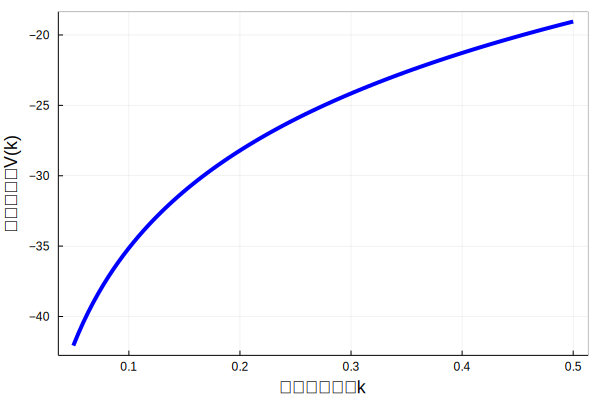

In [22]:
plt = plot(params.kgrid, valfn,
    color = :blue,
    legend = :none,
    xlabel = ("現在の資本：k"),
    ylabel = ("価値関数：V(k)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)

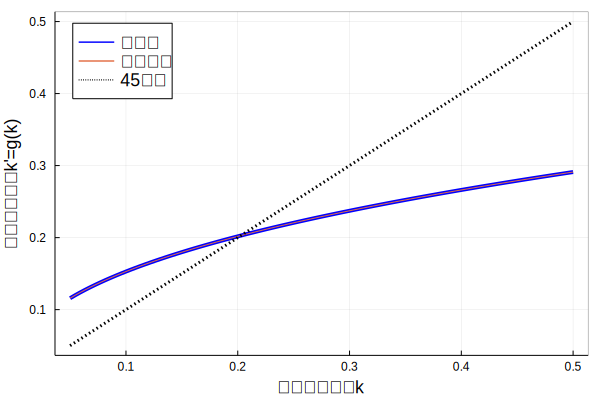

In [23]:
plt = plot(params.kgrid, pfcn0,
    color = :blue,
    legend = :topleft,
    label = ("近似解"),
    xlabel = ("現在の資本：k"),
    ylabel = ("次期の資本：k'=g(k)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.kgrid, p_true, linewidth = 1, label="解析的解")
plot!(params.kgrid, params.kgrid, linewidth = 3, color = "black", linestyle = :dot, label="45度線")

---

## エクササイズ
* グリッドを増やして、VFIとPFIの速度比較をしてみよう。